In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse.linalg import spsolve
import scipy.sparse as spa



def systemMatrix(M,N,a):
    """
    M: Number of rows
    N: Number of columns
    a: constant > 0
    ####
    return: matrix needed to solve the PDE
    ####
    Internal grid points require non-identity rows
    Now outdated, use sparseMatrix instead. Still usefull for visualizing the striped matrix
    """
    A = np.identity(M*N,dtype = float)
    repeatUnit = np.array([-1] + [0]*(N-1) + [-2*a, 4*a+2, -2*a] + [0]*(N-1) + [-1])
    for i in range(N+1, M*N - N -1,N):
        for j in range(N-2):
            A[i+j][i-(N+1)+j:i+N+2+j] = repeatUnit

    return A

def sparseMatrix(M,N,a):
    """
    Creates a sparse matrix used to solve the anisotropic Poisson equation for heatflow
    M: int, number of rows in the discretization grid
    N: int, number of columns in the discretization grid
    a: float, positive number which adjusts heatflow along d2
    ###
    return: The sparse system matrix, is (M*N)x(M*N) dimensional
    """
    
    #We need the 5 diagonals for the striped matrix

    #First the diagonals with {-1} elements
    internal = np.array([[-1]*(N-2) + [0]*2]*(M-2)).flatten()
    ends = np.zeros(N-1,dtype = float)

    sub1 = np.concatenate((internal,np.zeros(N-1)))
    sup1 = np.concatenate((np.zeros(N+1),internal[0:-2]))
    
    #Now the diagonals with {\alpha} and 0 elements
    intAlph = np.array([[-a]*(N-2) + [0]*2]*(M-2)).flatten()
    
    subAlph = np.concatenate((np.zeros(N),intAlph,np.zeros(N-1)))
    supAlph = np.concatenate((np.zeros(N+1),intAlph,np.zeros(N-2)))
    
    #Finally the diagonal itself, consists of {\beta} and ones
    intBet = np.array([[2*a+2]*(N-2) + [1]*2]*(M-2)).flatten()
    Beta = np.concatenate((np.ones(N+1),intBet,np.ones(N-1)))
    
    #At last we can make a sparse matrix
    A = spa.diags([sub1,subAlph,Beta,supAlph,sup1], [-N-1,-1,0,1,N+1],format = "csr")
    
    return A

def solvePDE(M,N,a,F):
    """
    ###
    Solves the PDE -(k*\nabla)**2 = F
    ###
    M: int, number of rows in the discretization grid
    N: int, number of columns in the discretization grid
    a: float, positive number which adjusts heatflow along d2 and d2
    F: the right hand side of the equation, includes the boundaries, will be scaled 
    ####
    return:
    xv: array, x-coordinates on the soultion grid
    yv: array, y-coordinates on the solution grid
    U: array, the solution to the PDE
    """
    #step size
    h = 1/N

    #grid
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,M)
    xv,yv = np.meshgrid(x,y)
    
    #The heat source vector
    F = F.flatten()*h**2
    
    #system
    sys = sparseMatrix(M,N,a)
    U = spsolve(sys,F)
    U = U.reshape(M,N)
    
    return xv,yv,U
    
def error(M,N,func, F, a = 2,plot = False):
    """
    computes the biggest error between the analytic and numerical solution.
    M: int, rows of discretized grid
    N: int, columns of the discretized grid
    func: function, the analytic solution to compare against
    F: right hand side of the hetrogenous PDE
    a: float, positive number which changes the relation of heatflow along d1 and d2 
    ####
    return: The largest error between the analytic and numerical solution
    """

    #numerical solution
    xv,yv,U = solvePDE(M,N,a,F)
        
    #analytic solution
    fasit = f(xv,yv)
    
    resid = fasit - U
    E = np.amax(abs(resid[-2]))
    
    if plot:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xv,yv,resid,cmap=cm.coolwarm)
        ax.view_init(azim=30)
        ax.set_ylabel("y")
        ax.set_xlabel("x")
        ax.set_zlabel("Heat")
        plt.show()
    
    return E

#Our test function
def f(x,y):
    return x**3 + 2*y**2

def LU(x,y,a):
    return -(a+1)*6*x -4

(64, 64)


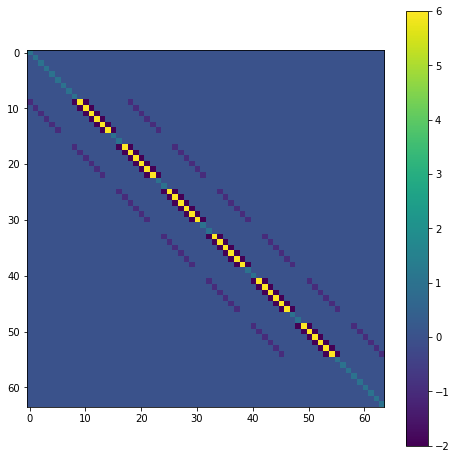

In [2]:
#Matrix structure
test = sparseMatrix(8,8,2).toarray()
print(np.shape(test))
fig = plt.figure(figsize = (8,8))
im = plt.imshow(test)
cbar = plt.colorbar(im)
#plt.savefig("structure.pdf")
plt.show()


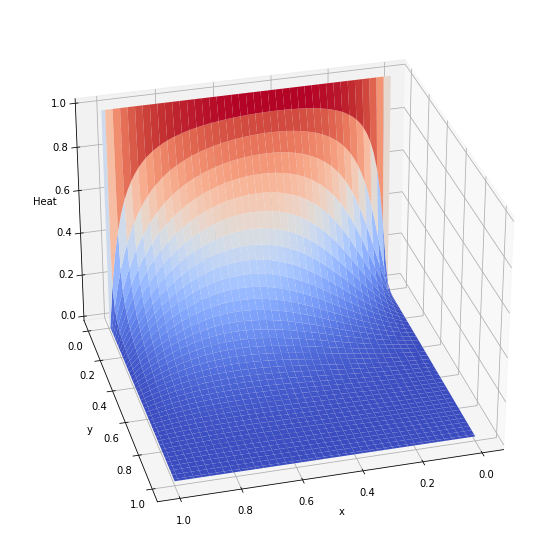

In [3]:
M = N = 80
a = 2
H = np.zeros((M,N),dtype = float)
H[0] = 1

a,b,c = solvePDE(M,N,a,H)
c = c*N**2

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a,b,c,cmap=cm.coolwarm)
ax.view_init(azim=75)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("Heat")
#plt.savefig("simpleSol.pdf")
plt.show()

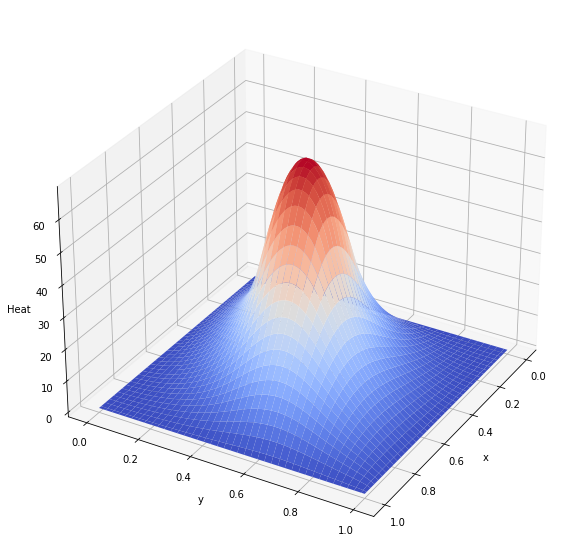

In [4]:
M = N = 80
a = 2
H = np.zeros((M,N),dtype = float)
H[30:50,30:50] = 1

a,b,c = solvePDE(M,N,a,H)
c = c*N**2

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a,b,c,cmap=cm.coolwarm)
ax.view_init(azim=30)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("Heat")
#plt.savefig("internalSol.pdf")
plt.show()

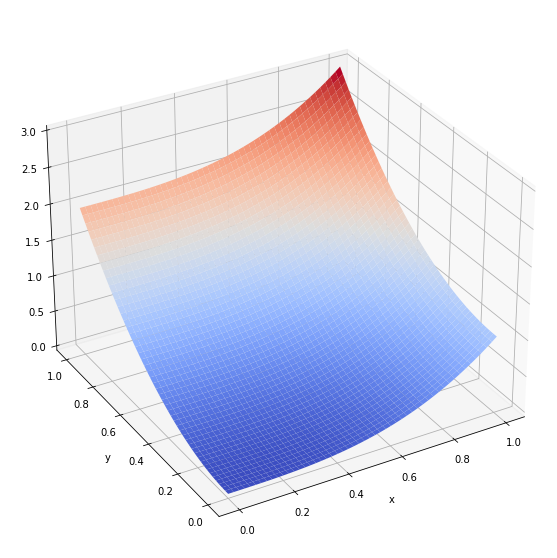

In [5]:
def forcedSol(M,N,func, A = 2):
    """
    Makes an appropriate right hand side to use with PDEsolver, to get a known solution
    ####
    inputs
    M: int, number of steps in the x-direction
    N: int, number of steps in the y-direction, must equal M to work with error()
    func: function, the known solution one wishes to check against
    A: float, A>0, rate of heatflow along d2
    ###
    return
    xs: array, x-coordinates to go with the right hand side
    ys: array, y-coordiantes to go with the right hand side
    test: array, the right hand side to use with error()
    """
    h = 1/N
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,M)
    xs,ys = np.meshgrid(x,y)

    analytic = func(xs,ys)
    operator = LU(xs,ys,A)

    test = np.copy(analytic) #fixing the boundaries
    test[1:-1,1:-1] = operator[1:-1,1:-1]*h*h #setting the interiour to match the analytic operator
    test = test/(h**2)
    return xs,ys,test



M = 500
N = 500
A = 2

xv,yv,test = forcedSol(M,N,f)
xv,yv,U = solvePDE(M,N,A,test)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv,yv,U,cmap=cm.coolwarm)
ax.view_init(azim=240)
ax.set_xlabel("x")
ax.set_ylabel("y")
#plt.savefig("500poly.pdf")
plt.show()



In [6]:
#a good bit of  runtime here, do not run unnecessarily.
MArr = np.array([10] + [i for i in range(25,501,25)])
hArr = 1/MArr

rightHands = [forcedSol(MArr[i],MArr[i],f)[2] for i in range(len(MArr))]
errArr = np.array([error(MArr[i],MArr[i],f, rightHands[i]) for i in range(len(MArr))])

Convegence rate by linear regression of the logarithms of errors and stepsizes: 1.9520525595328486
Step wise convergence rates: [0.9243561217756917, 0.6318720626269564, 0.7376743274484067, 0.7943480063839635, 0.8306124798525898, 0.855603947348109, 0.8740771105217024, 0.8883129097497229, 0.89990042903033, 0.9085178923171349, 0.9164270064590081, 0.923006497206149, 0.928531584290186, 0.9333143357027193, 0.9375397111489058, 0.9414735823143288, 0.9440026370709632, 0.9474015708328575]


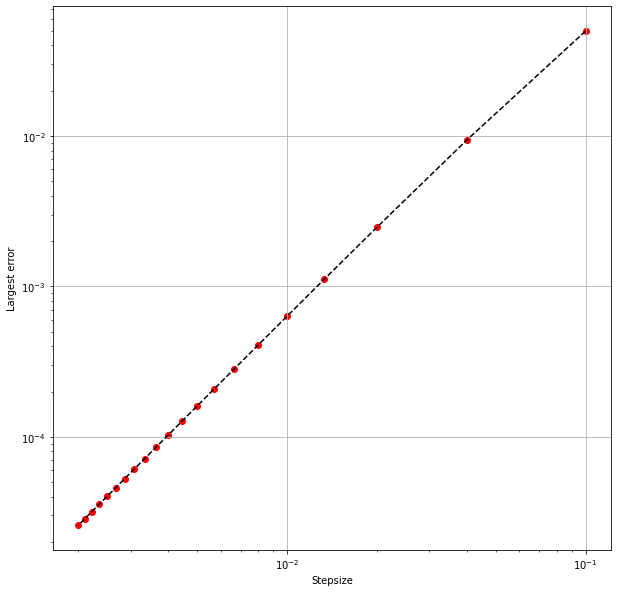

In [7]:
order = np.polyfit(np.log(hArr),np.log(errArr),1)[0]
print(f"Convegence rate by linear regression of the logarithms of errors and stepsizes: {order}")

def rates(arr):
    """
    Approximate rate of convergence at each point in the array
    Based on this: https://en.wikipedia.org/wiki/Rate_of_convergence#Order_estimation
    """
    qArr = []
    for i in range(2,len(arr)-1):
        q = np.log(abs((arr[i+1] - arr[i]) / (arr[i] - arr[i-1]))) / np.log(abs( (arr[i] - arr[i-1]) / (arr[i-1] - arr[i-2])))
        qArr.append(q)
    return qArr

check = rates(errArr)
print(f"Step wise convergence rates: {check}")

plt.figure(figsize = (10,10))
plt.scatter(hArr,errArr,c = 'r')
plt.loglog(hArr,errArr,'--k')
plt.xlabel("Stepsize")
plt.ylabel("Largest error")
plt.grid()
plt.savefig("simpleError.pdf")
plt.show()

64


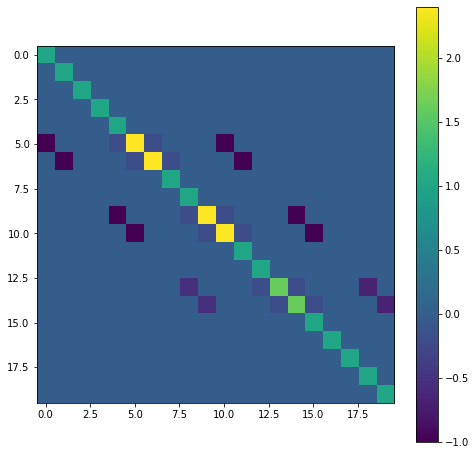

(65, 90)
(65, 90) (65, 90)


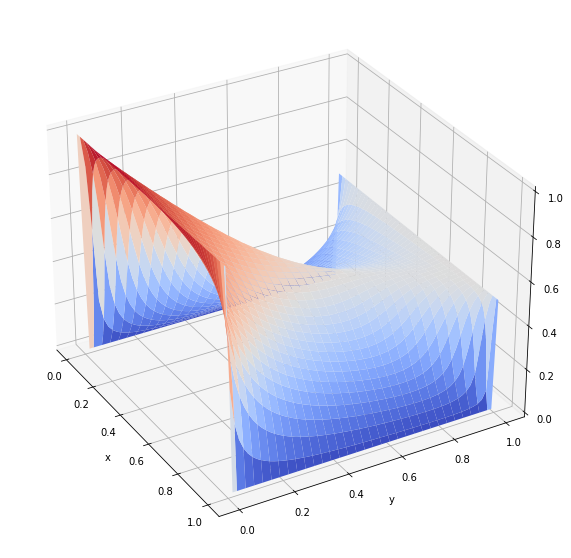

In [8]:
#1d
def sparseMatrixV2(M,N,a,r):
    """
    Creates a sparse matrix used to solve the anisotropic Poisson equation for heatflow, now with arbitrary d2
    The major changes are the factors in the last block of internal grid points, and that the number of rows is decided
    by the length of k.
    M: int, number of rows in the discretization grid
    N: int, number of columns in the discretization grid
    a: float, positive number which adjusts heatflow along d2
    r: float, the y-coordinate of d2
    ###
    return: The sparse system matrix, is (M*N)x(M*N) dimensional
    """
    #How long is the last step?
    h = 1/N                  #step in x direction
    k = abs(r)*h             #step i y direction
    k_f = (1/k - 1//k)*k     #The last step is this long.
    A = 2/(k+k_f)

    #We need the 5 diagonals for the striped matrix
    #To get the same behaviour as earlier, we stil multiply with h^2, so we solve AU = F*h^2

    #First the diagonals with {-1} elements
    internal1 = np.array([[-1]*(N-2) + [0]*2]*(M-3) + [[-h*h*A/k]*(N-2) + [0]*2]).flatten()
    internal2 = np.array([[-1]*(N-2) + [0]*2]*(M-3) + [[-h*h*A/k_f]*(N-2) + [0]*2]).flatten()
    ends = np.zeros(N-1,dtype = float)

    sub1 = np.concatenate((internal1,np.zeros(N-1)))
    sup1 = np.concatenate((np.zeros(N+1),internal2[0:-2]))
    
    #Now the diagonals with {\alpha} and 0 elements
    intAlph = np.array([[-a]*(N-2) + [0]*2]*(M-2)).flatten()
    
    subAlph = np.concatenate((np.zeros(N),intAlph,np.zeros(N-1)))
    supAlph = np.concatenate((np.zeros(N+1),intAlph,np.zeros(N-2)))
    
    #Finally the diagonal itself, consists of {\beta} and ones
    intBet = np.array([[2*a+2]*(N-2) + [1]*2]*(M-3) + [[2*a+h*h*A/k_f + h*h*A/k]*(N-2) + [1]*2]).flatten()
    Beta = np.concatenate((np.ones(N+1),intBet,np.ones(N-1)))
    
    #At last we can make a sparse matrix
    Arr = spa.diags([sub1,subAlph,Beta,supAlph,sup1], [-N-1,-1,0,1,N+1],format = "csr")
    
    return Arr

def solvePDE_V2(M,N,a,r,F):
    """
    ###
    Solves the PDE -(k*\nabla)**2 = F
    ###
    M: int, number of rows in the discretization grid
    N: int, number of columns in the discretization grid
    a: float, positive number which adjusts heatflow along d2 and d2
    r: float, the y-coordinate of d2
    F: the right hand side of the equation, includes the boundaries, will be scaled 
    ####
    return:
    xv: array, x-coordinates on the soultion grid
    yv: array, y-coordinates on the solution grid
    U: array, the solution to the PDE
    """
    #step size
    h = 1/N
    k = abs(r)*h
    k_f = (1/k - 1//k)*k

    #grid
    x = np.linspace(0,1,N)
    y = np.array([i*k for i in range(M)]+[1])
    xv,yv = np.meshgrid(x,y)
    
    #The heat source vector
    F = F.flatten()*h**2
    
    #system
    sys = sparseMatrixV2(len(y),len(x),a,r)
    U = spsolve(sys,F)
    U = U.reshape(len(y),len(x))
    
    return xv,yv,U

N = 90
r = 2**0.5   #The bad, irrational y coordinate direction
h = 1/N
k = abs(r)*h
M = int((1 // k)+1)
print(M)

test2 = sparseMatrixV2(5,4,0.2,r).toarray()
fig = plt.figure(figsize = (8,8))
im2 = plt.imshow(test2)
cbar = plt.colorbar(im2)
#plt.savefig("newSystem.pdf")
plt.show()

heatness = np.zeros((M+1,N),dtype = float)
heatness[0] = 1/h**2
heatness[-1] = 0.5/h**2
xv,yv,test2 = solvePDE_V2(M,N,0.3,r,heatness)
print(np.shape(test2))
print(np.shape(xv),np.shape(yv))

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv,yv,test2,cmap=cm.coolwarm)
ax.view_init(azim=-30)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("irrational_2.pdf")
plt.show()

Convergence rate by linear regression of the logarithms of errors and stepsizes: 1.000389898706244


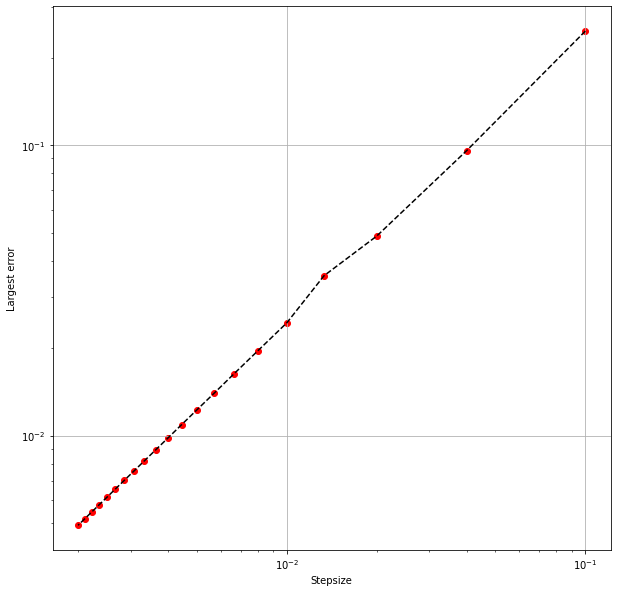

In [9]:
def g(x,y):
    return np.exp(-x)*np.cos(y)

def LU2(x,y,a,r):
    return -(a+1)*np.exp(-x)*np.cos(y) - 2*r*np.exp(-x)*np.sin(y) + np.exp(-x)*np.cos(y)*r**2

def forcedSol_V2(M,N,r,func, A = 3):
    """
    Makes an appropriate right hand side to use with PDEsolver, to get a known solution
    ####
    inputs
    M: int, number of steps in the x-direction
    N: int, number of steps in the y-direction, must equal M to work with error()
    func: function, the known solution one wishes to check against
    A: float, A>0, rate of heatflow along d2
    ###
    return
    xs: array, x-coordinates to go with the right hand side
    ys: array, y-coordiantes to go with the right hand side
    test: array, the right hand side to use with error()
    """
    h = 1/N
    k = abs(r)*h

    x = np.linspace(0,1,N)
    y = np.array([i*k for i in range(M)] + [1])
    xs,ys = np.meshgrid(x,y)

    analytic = func(xs,ys)
    operator = LU2(xs,ys,A,r)

    test = np.copy(analytic) #fixing the boundaries
    test[1:-1,1:-1] = operator[1:-1,1:-1]*h*h #setting the interior to match the analytic operator
    test = test/(h**2)
    return xs,ys,test


def error_V2(M,N,r,f, F, a = 3,plot = False):
    """
    computes the biggest error between the analytic and numerical solution.
    M: int, rows of discretized grid
    N: int, columns of the discretized grid
    r: float, the y-coordinate of d2
    func: function, the analytic solution to compare against
    F: right hand side of the hetrogenous PDE
    a: float, positive number which changes the relation of heatflow along d1 and d2 
    ####
    return: The largest error between the analytic and numerical solution
    """

    #numerical solution
    xv,yv,U = solvePDE_V2(M,N,a,r,F)
        
    #analytic solution
    fasit = f(xv,yv)
    
    resid = fasit - U
    E = np.amax(abs(resid[:,-2]))
    
    if plot:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xv,yv,resid,cmap=cm.coolwarm)
        ax.view_init(azim=30)
        ax.set_ylabel("y")
        ax.set_xlabel("x")
        ax.set_zlabel("Heat")
        plt.show()
    
    return E


r = 2**0.5   #The bad, irrational y-coordinate direction

Narr = np.array([10]+[i for i in range(25,501,25)])
harr = 1/Narr
kArr = abs(r)*harr
Marr = np.array(1 // kArr +1,dtype = int)

rH = [forcedSol_V2(Marr[i],Narr[i],r,f)[2] for i in range(len(Marr))]
errArr2 = np.array([error_V2(Marr[i],Narr[i],r,f, rH[i]) for i in range(len(Marr))])

order = np.polyfit(np.log(harr),np.log(errArr2),1)[0]
print(f"Convergence rate by linear regression of the logarithms of errors and stepsizes: {order}")

plt.figure(figsize = (10,10))
plt.scatter(harr,errArr2,c = 'r')
plt.loglog(harr,errArr2,'--k')
plt.xlabel("Stepsize")
plt.ylabel("Largest error")
plt.grid()
#plt.savefig("newError.pdf")
plt.show()

Convergence rate by linear regression of the logarithms of errors and stepsizes: 1.2966239289110584


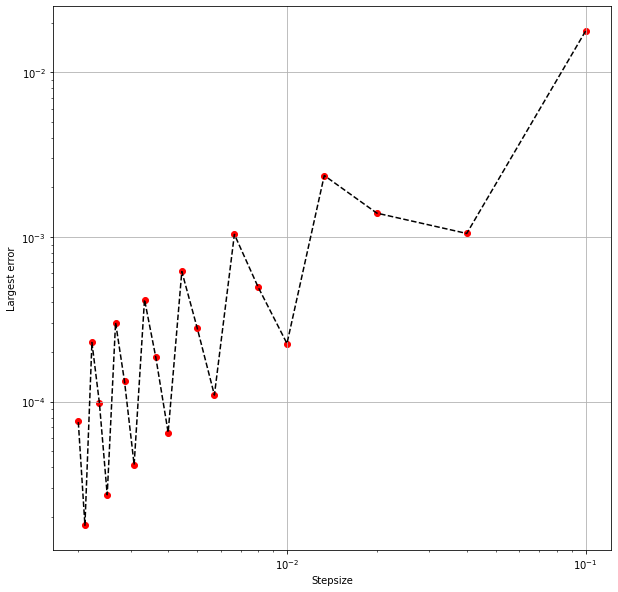

In [10]:
rH = [forcedSol_V2(Marr[i],Narr[i],r,g)[2] for i in range(len(Marr))]
errArr2 = np.array([error_V2(Marr[i],Narr[i],r,g, rH[i]) for i in range(len(Marr))])

order = np.polyfit(np.log(harr),np.log(errArr2),1)[0]
print(f"Convergence rate by linear regression of the logarithms of errors and stepsizes: {order}")

plt.figure(figsize = (10,10))
plt.scatter(harr,errArr2,c = 'r')
plt.loglog(harr,errArr2,'--k')
plt.xlabel("Stepsize")
plt.ylabel("Largest error")
plt.grid()
#plt.savefig("newError.pdf")
plt.show()

50


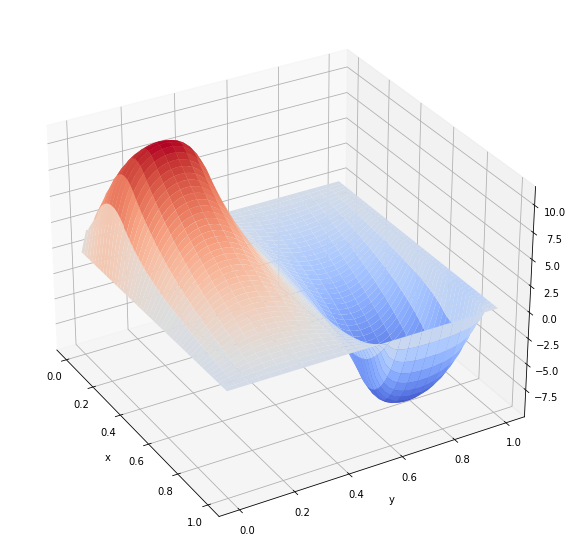

In [11]:
#1d "An interesting case"
N = 500
h = 1/N
r2 = np.pi**2
k = abs(r2)*h
M = int((1 // k))
a = 1000
print(M)
F = np.zeros((M+1,N),dtype = float)
F[1:20,0:120] = 2
F[-20:-2,-120:-2] = -2


stuff = solvePDE_V2(M,N,a,r2,F)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(stuff[0],stuff[1],stuff[2]*N**2,cmap=cm.coolwarm)
ax.view_init(azim=-30)
ax.set_xlabel("x")
ax.set_ylabel("y")
#plt.savefig("irrational_3.pdf")
plt.show()


/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


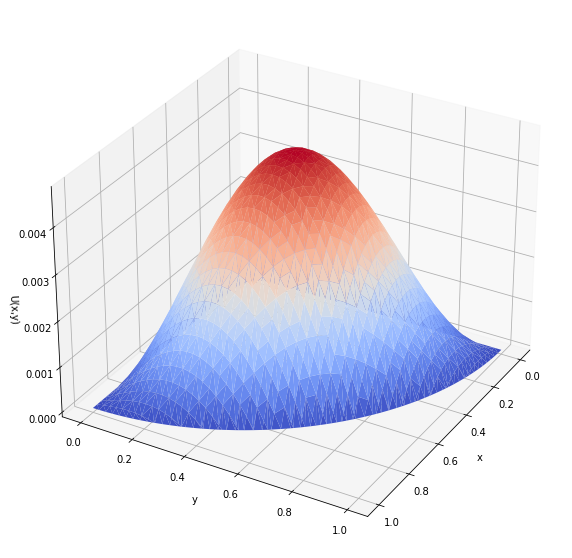

In [12]:
#Problem 2, isotropic on unit disk in first quadrant
def g(z): #Dirichlet B.C.
    return 0

def gamma3(x):
    return np.sqrt(1-x**2)

#create normal NxN grid, and then start selecting points for our modified grid
def GRID(N):
    """
    Creates grid for solving Dirichlet B.C. problem
    ####
    Inputs
    N: int, number of steps in both x- and y-direction
    ####
    returns
    newGr: array, containing (x,y)-coordinates for the points in our grid
    """
    X= np.linspace(0,1,N+1)
    Y= np.linspace(0,1,N+1)
    Grid = []
    for y in Y:
        for x in X:
            Grid.append([x,y])
    newGr = []
    for pts in Grid:
        #print(pts)
        if not pts[0]**2 + pts[1]**2 >1:
            newGr.append(pts)
    
    for x in X:
        if [x,gamma3(x)]!=[1,0] and [x,gamma3(x)]!=[0,1]:
            newGr.append([x,gamma3(x)])
    for y in Y:
        if [gamma3(y),y]!=[1,0] and [gamma3(y),y]!=[0,1]:
            newGr.append([gamma3(y),y])
    newGr = sorted(newGr , key=lambda k: [k[1], k[0]])
    return newGr

def f(z):#the RHS in -\delta T = f
    x,y = z[0],z[1]
    return x*y*(1-x**2-y**2)

def solveMod(N,g,f):
    """
    solves the B.C. problem on the grid created in GRID(N)
    ####
    inputs
    N: int, number of steps in x- and y-direction
    g: function, boundary condition
    f: function, the RHS in our PDE -\delta T = f
    ####
    returns
    Grid: array, the array created from running GRID(N)
    U: array, contains the numerical solution to the PDE
    """
    Grid = GRID(N)
    h=1/N
    G = len(Grid)
    #print(G)
    A = np.zeros((G,G))
    F = np.zeros(G)
    #print(A)
    for P in Grid:
        k = Grid.index(P)
        Px = P[0]
        Py = P[1]
        
        
        if Px == 0 or Py == 0 or np.abs(Px**2+Py**2 -1) <1e-8:#boundary points get 1 on their diagonal, and rest 0
            A[k][k]=1
            F[k] = g(Grid[k])
        #now for interior points:
        #must find what is N,S,E,W for each interior point
        else:
            #print(P)
            eta1 = np.min([(np.sqrt(1-Py**2)-Px)/h,1])
            #print(eta1)
            eta2 = np.min([(np.sqrt(1-Px**2)-Py)/h,1])
            #print(eta2)
            #coefficients for modified -L_h
            ap = -2/(h**2 *eta1)
            aw = 2/(h**2 * (eta1+1))
            ae = 2/(h**2 * eta1 *(eta1+1))
        
            bp = -2/(h**2 *eta2)
            bs = 2/(h**2 * (eta2+1))
            bn = 2/(h**2 * eta2 *(eta2+1))
            #search for N,E,S,W for each P
            So = np.where(np.all(np.isclose([Px,Py-h],Grid),axis=1))[0][0]
            Ea = np.where(np.all(np.isclose([Px+eta1*h,Py],Grid),axis=1))[0][0]
            No = np.where(np.all(np.isclose([Px,Py+eta2*h],Grid),axis=1))[0][0]
            We = np.where(np.all(np.isclose([Px-h,Py],Grid),axis=1))[0][0]
            
            A[k][k] = -ap-bp
            A[k][So] = -bs
            A[k][Ea] = -ae
            A[k][No] = -bn
            A[k][We] = -aw
            
            F[k] = f(Grid[k])
            
    U = spsolve(A,F)
    return Grid, U



Gridd, Uf = solveMod(40,g,f)
X = [p[0]for p in Gridd]
Y = [p[1]for p in Gridd]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X,Y,Uf,cmap=cm.coolwarm)
ax.view_init(azim=30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("U(x,y)")
#plt.savefig("oppg2Mod.pdf")
plt.show()

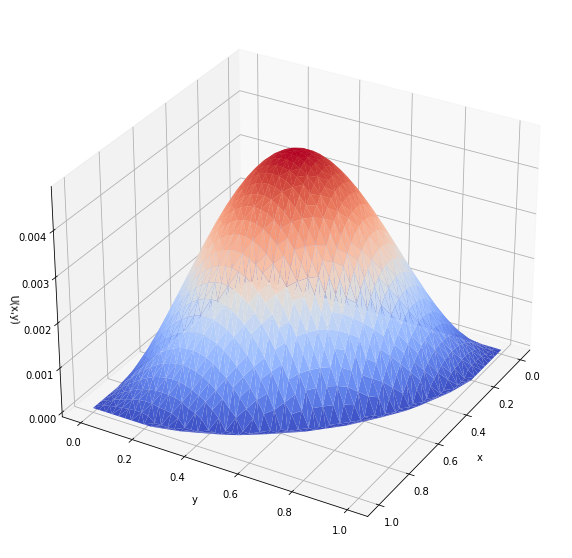

In [13]:
def GridFatten(N,c):
    """
    Creates grid for fattening the boundary solution to the PDE
    ####
    inputs
    N: int, number of steps in x- and y-direction
    c: float, constant which decides how much we fatten the boundary
    ####
    returns
    newGr: array, containing all gridpoints which we need to solve PDE
    """
    X=np.linspace(0,1,N+1)
    Y = np.linspace(0,1,N+1)
    h=1/N
    Grid = []
    for y in Y:
        for x in X:
            Grid.append([x,y])
    newGr =[]
    for p in Grid:
        if not p[0]**2 + p[1]**2 >1:#interior pts
            newGr.append(p)
        elif (1<=p[0]**2 + p[1]**2) and (p[0]**2+p[1]**2<(1+c)**2):
            newGr.append(p)
    newGr = sorted(newGr , key=lambda k: [k[1], k[0]])
    #print(newGr)
    return newGr

def FattenSolve(N,g,f,c):
    """
    Solves PDE by fattening the boundary
    ####
    inputs
    N: int, number of steps in x- and y- directions
    g: function, Dirichlet Boundary Condition
    f: function, the RHS in the PDE
    c: float, constant which decides how much we fatten the boundary
    ####
    returns
    Grid: array, the grid created by GridFatten(N,c)
    U: array, the numerical solution to the PDE
    """
    Grid = GridFatten(N,c)
    h=1/N
    G = len(Grid)
    A = np.zeros((G,G))
    F = np.zeros(G)
    for P in Grid:
        k = Grid.index(P)
        Px = P[0]
        Py = P[1]
        
        
        if Px == 0 or Py == 0 or (1<= Px**2+Py**2) :#boundary points get 1 on their diagonal, and rest of the row stays 0
            A[k][k]=1
            F[k] = g(Grid[k])
        else:
            #find index of the N,E,S,W nodes for each P        
            So = np.where(np.all(np.isclose([Px,Py-h],Grid),axis=1))[0][0]
            Ea = np.where(np.all(np.isclose([Px+h,Py],Grid),axis=1))[0][0]
            No = np.where(np.all(np.isclose([Px,Py+h],Grid),axis=1))[0][0]
            We = np.where(np.all(np.isclose([Px-h,Py],Grid),axis=1))[0][0]
            
            A[k][k] = 4/h**2
            A[k][So] = -1/h**2
            A[k][Ea] = -1/h**2
            A[k][No] = -1/h**2
            A[k][We] = -1/h**2
            
            F[k] = f(Grid[k])
    U = spsolve(A,F)
    return Grid,U


Gridfat, Ufat = FattenSolve(40,g,f,0.03)
X = [p[0]for p in Gridfat]
Y = [p[1]for p in Gridfat]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X,Y,Ufat,cmap=cm.coolwarm)
ax.view_init(azim=30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("U(x,y)")
#plt.savefig("oppg2Fat.pdf")
plt.show()

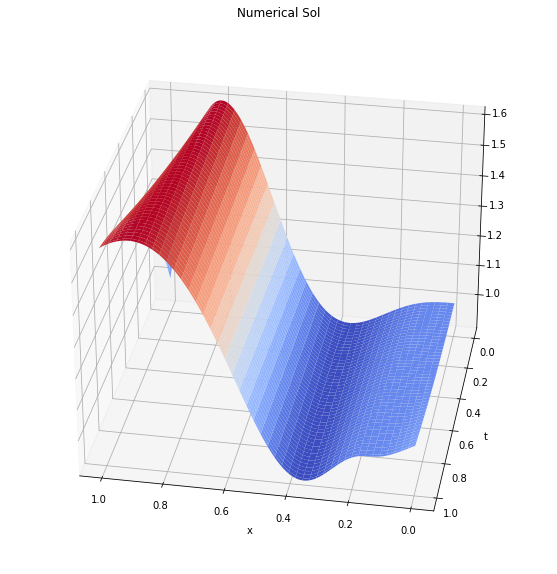

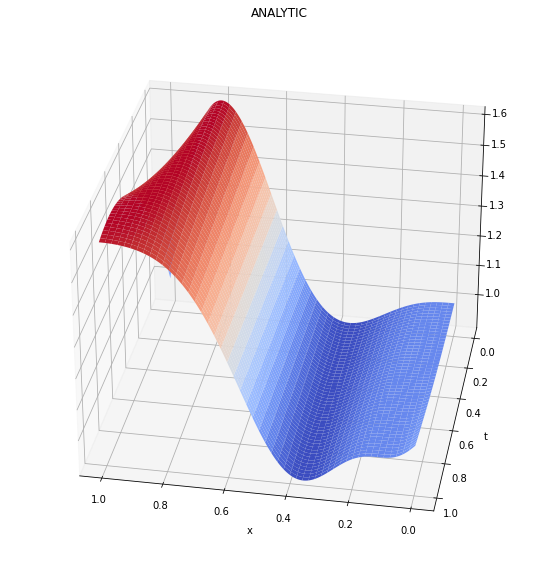

In [14]:
#UPwind implementation
def a(x,t):
    return (x-1/3)*(x-2/3)
def r_pos(r):
    return np.fmax(r,0)
def r_neg(r):
    return r_pos(-r)
def u_0(x):
    return 1-np.sin(2*np.pi*x)*x**2
def g(t):
    return u_0(-a(0,t)*t)
def uanal(x,t):
    return u_0(x-a(x,t)*t)


def upWind(a,M,N,u_0,g,T):
    """
    solves the PDE with upwind scheme method.
    ####
    inputs
    a: function, variable coefficient
    M: int, number of steps in x-direction
    N: int, number of steps in t-direction
    u_0: function, u(x,0)=u_0(x). function value along t=0
    g: function, u(0,t) = g(t). function value along x=0
    T: int, end time
    ####
    returns
    x: array, array of x-values
    t: array, array of t-values
    U: array, numerical solution to PDE
    """
    x = np.linspace(0,1,M+1)
    t = np.linspace(0,T,N+1)

    k=T/(N)
    h=1/(M)

    r = a(x,t)*k/h
    
    U = np.zeros((N+1,M+1),dtype=float) #U, array to insert our numerical sol'n
    
    rp = np.vectorize(r_pos)(r)
    rn = np.vectorize(r_neg)(r)


    A = spa.diags([rp[1:], 1-rp[:] -rn[:], rn[:-1]],[-1,0,1]).toarray()
    #U[:,0] = np.vectorize(u_0)(x)
    U[0,:] = np.vectorize(u_0)(x)

    for n in range(N):
        U[n+1,:]=A.dot(U[n,:])
        U[n+1,0]= g(t[n+1])
    

    return x,t,U

xU,tU,UpW = upWind(a,400,1000,u_0,g,1)
X,T= np.meshgrid(xU,tU)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T,UpW,cmap=cm.coolwarm)
ax.view_init(azim=100)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Numerical Sol")
plt.show()

xAn = np.linspace(0,1,1000)
tAn = np.linspace(0,1,1000)
XA,TA = np.meshgrid(xAn,tAn)

fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot(111, projection='3d')
ax.plot_surface(XA,TA,uanal(XA,TA),cmap=cm.coolwarm)
ax.view_init(azim=100)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("ANALYTIC")
plt.show()



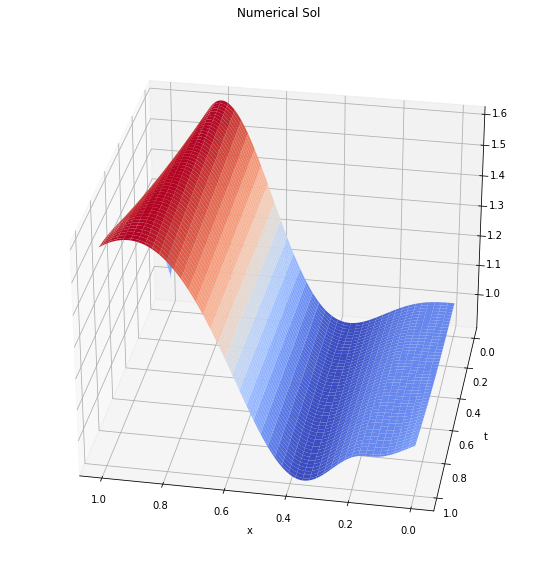

In [15]:
#lAX WENDRoffff
def da(x):
    return 2*x-1

def LaxWendroff(a,da,T,M,N,u_0,g):
    """
    solves the PDE with Lax-Wendroff method.
    ####
    inputs
    a: function, variable coefficient
    da: function, d(a(x))/dx, derivative of a(x)
    M: int, number of steps in x-direction
    N: int, number of steps in t-direction
    u_0: function, u(x,0)=u_0(x). function value along t=0
    g: function, u(0,t) = g(t). function value along x=0
    T: int, end time
    ####
    returns
    x: array, array of x-values
    t: array, array of t-values
    U: array, numerical solution to PDE
    """
    x = np.linspace(0,1,M+1)
    t = np.linspace(0,T,N+1)

    k=T/(N)
    h=1/(M)

    def r(x):
        return a(x,t)*k/h
    U = np.zeros((N+1,M+1),dtype=float) #U, array to insert our numerical sol'n
    rv = np.vectorize(r)(x)
    dav = np.vectorize(da)(x)

    A = spa.diags([(rv[1:])**2 / 2- k*rv[1:]*dav[1:]/4+rv[1:]/2, 1-(rv[:])**2, (rv[:-1])**2 / 2 + k*rv[:-1]*dav[:-1]/4-rv[:-1]/2],[-1,0,1]).toarray()

    #U[:,0] = np.vectorize(u_0)(x)
    U[0,:] = np.vectorize(u_0)(x)

    for n in range(N):
        U[n+1,:]=A.dot(U[n,:])
        U[n+1,0]= g(t[n+1])
        U[n+1,M]= U[n+1,M-1]

    return x,t,U

xL,tL, UL = LaxWendroff(a,da,1,400,1000,u_0,g)
X,T = np.meshgrid(xL,tL)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T,UL,cmap=cm.coolwarm)
ax.view_init(azim=100)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Numerical Sol")
plt.show()

Convergence space: 1.5493793177362702
Convergence time: 1.8208711076026127


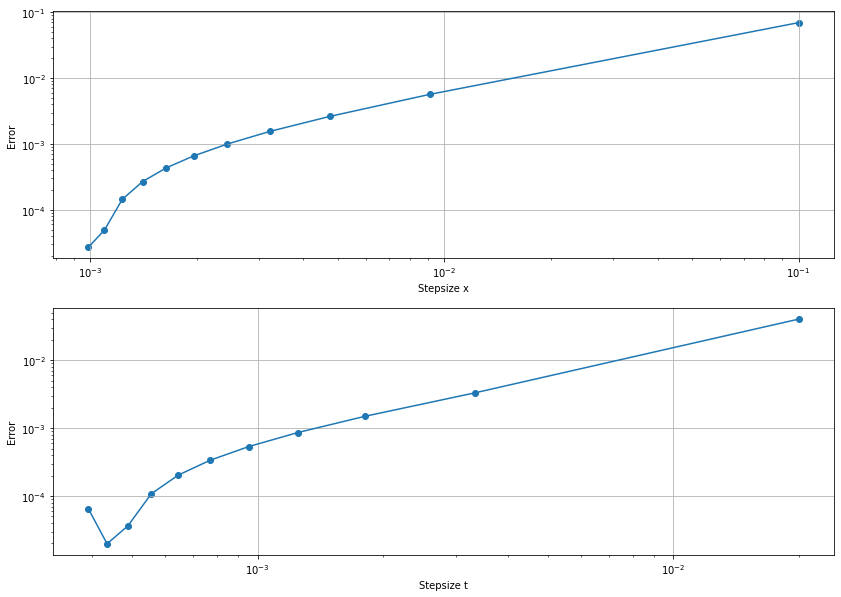

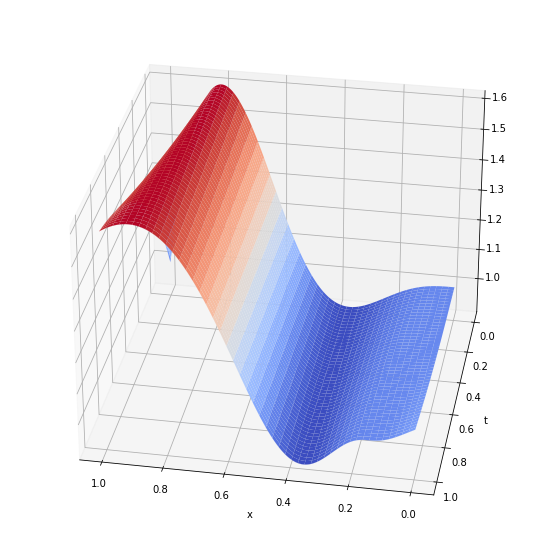

In [16]:
#conv. plots for Upwind:

#CFL:
#M/N <= 9/2
xtest,ttest,Utest = upWind(a,1000,10000,u_0,g,1)
fasit1 = np.amax(abs(Utest[:,-2]))
fasit2 = np.amax(abs(Utest[-2]))

xArr = np.array([i for i in range(10,1011,100)])  #M
tArr = np.array([j for j in range(50, 2551,250)]) #N

numArr = [upWind(a,xArr[i],tArr[i],u_0,g,1) for i in range(len(xArr))]       #numerical solutions
meshArr = [np.meshgrid(numArr[i][0],numArr[i][1]) for i in range(len(xArr))] #meshgrids

eArr = [abs(fasit1 - np.amax(abs(numArr[i][-1][:,-2]))) for i in range(len(xArr))] #Errors
eArr2 = [abs(fasit2 - np.amax(abs(numArr[i][-1][-2]))) for i in range(len(xArr))]

fig, ax = plt.subplots(2,figsize = (14,10))
ax[0].scatter(1/xArr,eArr2)
ax[0].loglog(1/xArr,eArr2)
ax[0].grid()
ax[0].set_ylabel("Error")
ax[0].set_xlabel("Stepsize x")
orderx = np.polyfit(np.log(1/xArr),np.log(eArr),1)[0]
print(f"Convergence space: {orderx}")

ordert = np.polyfit(np.log(1/tArr),np.log(eArr),1)[0]
print(f"Convergence time: {ordert}")

ax[1].scatter(1/tArr,eArr)
ax[1].loglog(1/tArr,eArr)
ax[1].grid()
ax[1].set_xlabel("Stepsize t")
ax[1].set_ylabel("Error")
#plt.savefig("WindError.pdf")
plt.show()


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meshArr[-1][0],meshArr[-1][1],numArr[-1][-1],cmap=cm.coolwarm)
ax.view_init(azim=100)
ax.set_xlabel("x")
ax.set_ylabel("t")
#ax.set_title("Numerical Sol")
#plt.savefig("WindFinest.pdf")
plt.show()

Convergence space: 1.5039509801504471
Convergence time: 1.70701888620652


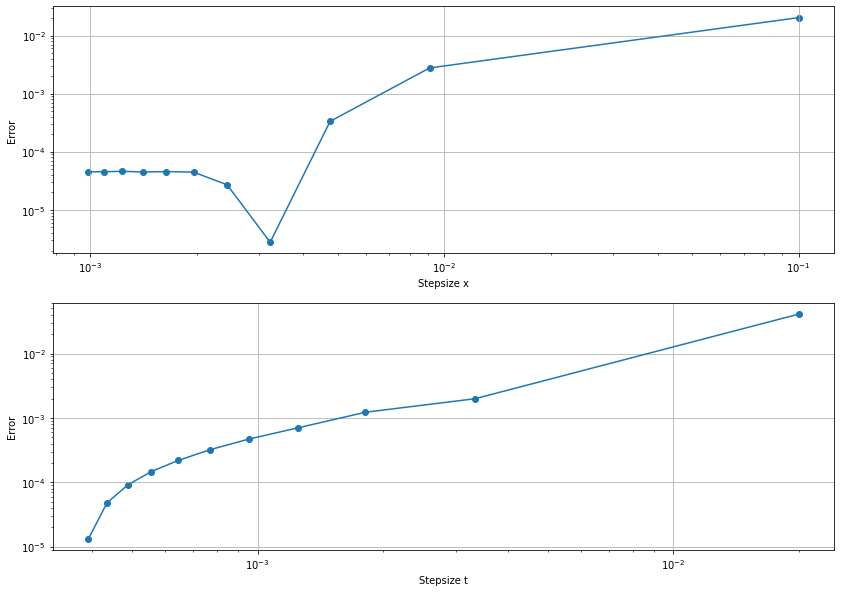

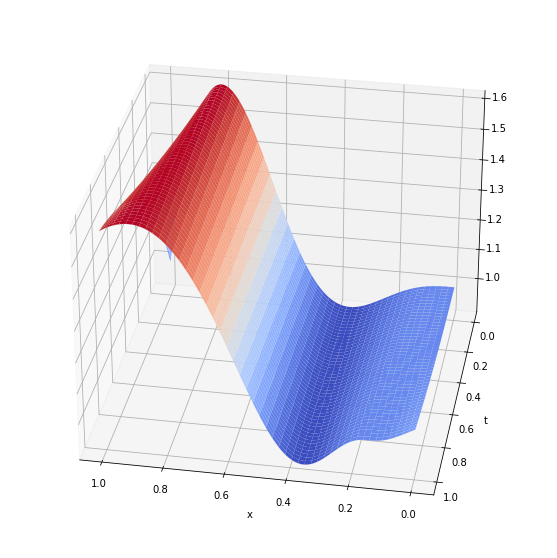

In [17]:
# Convergence for Lax wendroff

xRef,tRef, ref = LaxWendroff(a,da,1,1000,10000,u_0,g)
Lxfasit = np.amax(abs(ref[-2]))
Ltfasit = np.amax(abs(ref[:,-2]))

xArr2 = np.array([i for i in range(10,1011,100)])  #M
tArr2 = np.array([j for j in range(50, 2551,250)]) #N

numArr2 = [LaxWendroff(a,da,1,xArr[i],tArr[i],u_0,g) for i in range(len(xArr2))]       #numerical solutions
meshArr2 = [np.meshgrid(numArr[i][0],numArr[i][1]) for i in range(len(xArr2))]         #meshgrids

LeArr = [abs(Ltfasit - np.amax(abs(numArr2[i][-1][:,-2]))) for i in range(len(xArr2))] #Errors in time
LeArr2 = [abs(Lxfasit - np.amax(abs(numArr2[i][-1][-2]))) for i in range(len(xArr2))]  #Errors in space


fig, ax = plt.subplots(2,figsize = (14,10))
ax[0].scatter(1/xArr2,LeArr2)
ax[0].loglog(1/xArr2,LeArr2)
ax[0].grid()
ax[0].set_ylabel("Error")
ax[0].set_xlabel("Stepsize x")
orderx = np.polyfit(np.log(1/xArr2),np.log(LeArr),1)[0]
print(f"Convergence space: {orderx}")

ordert = np.polyfit(np.log(1/tArr2),np.log(LeArr2),1)[0]
print(f"Convergence time: {ordert}")

ax[1].scatter(1/tArr2,LeArr)
ax[1].loglog(1/tArr2,LeArr)
ax[1].grid()
ax[1].set_xlabel("Stepsize t")
ax[1].set_ylabel("Error")
#plt.savefig("LaxError.pdf")
plt.show()


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meshArr2[-1][0],meshArr2[-1][1],numArr2[-1][-1],cmap=cm.coolwarm)
ax.view_init(azim=100)
ax.set_xlabel("x")
ax.set_ylabel("t")
#ax.set_title("Numerical Sol")
#plt.savefig("LaxFinest.pdf")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=028d8d0c-737f-4a53-b133-d987680987d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>